In [1]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# Итак, к данному этапу Вы из массива изображений "восстановили" текст.
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.

# Импорт библиотек

In [2]:
!pip install opencv-python


[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import random
import string
from copy import deepcopy

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
path_to_folder = 'data'
characters = [x if x != "times" else "*" for x in os.listdir(path_to_folder)]
print(characters)

['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'h', 't', '*', 'w', 'X', 'y']


# Сгенерировать набор текстовых строк из допустимых символов.

In [5]:
# Сгенерировать набор текстовых строк из допустимых символов.
def generate_text_dataset(num_lines=100, min_line_length=10, max_line_length=50, characters=None):
    if characters is None:
        characters = string.ascii_letters + string.digits + " "
    dataset = []
    for _ in range(num_lines):
        line_length = random.randint(min_line_length, max_line_length)
        line = "".join(random.choices(characters, k=line_length))
        dataset.append(line)
    return dataset

In [6]:
generated_strings = generate_text_dataset(num_lines=10, min_line_length=10, max_line_length=20, characters=characters)
for str_ in generated_strings:
    print(str_)

,117t2X),168,6w2h
y361w)6,1X3h
031w*-yw96
7*5(76yh8hX74*h
47y7w+h6++
w4XwX30y9h5
06hww**Xhh8)46)w2t
*(w8-6t9(,*h)2X5tX15
-,+-4886*(839*h-95w8
63-*)+y+279)ww18,


# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.

In [7]:
def get_random_path_to_image(charachter):
    return os.path.join(path_to_folder, charachter if charachter != "*" else "times", random.choice(os.listdir(os.path.join(path_to_folder, charachter if charachter != "*" else "times"))))

In [8]:
images_str = dict()
for str_ in generated_strings:
    images_path = []
    for chr in str_:
        images_path.append(get_random_path_to_image(chr))
    images_str[str_] = images_path

In [9]:
images_str

{',117t2X),168,6w2h': ['data\\,\\exp83791.jpg',
  'data\\1\\exp87907.jpg',
  'data\\1\\exp17639.jpg',
  'data\\7\\exp1622.jpg',
  'data\\t\\exp67423.jpg',
  'data\\2\\2_47043.jpg',
  'data\\X\\exp67899.jpg',
  'data\\)\\exp56922.jpg',
  'data\\,\\,_35769.jpg',
  'data\\1\\1_3798.jpg',
  'data\\6\\exp99691.jpg',
  'data\\8\\8_23438.jpg',
  'data\\,\\exp84929.jpg',
  'data\\6\\exp93906.jpg',
  'data\\w\\exp74230.jpg',
  'data\\2\\exp26572.jpg',
  'data\\h\\exp75360.jpg'],
 'y361w)6,1X3h': ['data\\y\\exp61.jpg',
  'data\\3\\exp58335.jpg',
  'data\\6\\6_60879.jpg',
  'data\\1\\exp95758.jpg',
  'data\\w\\w_93112.jpg',
  'data\\)\\)_42184.jpg',
  'data\\6\\exp97475.jpg',
  'data\\,\\,_99440.jpg',
  'data\\1\\exp8471.jpg',
  'data\\X\\exp100257.jpg',
  'data\\3\\3_6014.jpg',
  'data\\h\\h_41834.jpg'],
 '031w*-yw96': ['data\\0\\0_69762.jpg',
  'data\\3\\3_5736.jpg',
  'data\\1\\exp51195.jpg',
  'data\\w\\w_79569.jpg',
  'data\\times\\exp47401.jpg',
  'data\\-\\exp70109.jpg',
  'data\\y\\Y_8488

In [10]:
IMAGE_SIZE = 45

def images_char_to_image_str(list_of_images):
    margin = 20
    image = Image.new("RGB", (len(list_of_images) * (IMAGE_SIZE + margin), IMAGE_SIZE * 2), (255, 255, 255))
    
    for k, image_ in enumerate(list_of_images):
        image.paste(image_, (k * (IMAGE_SIZE + margin), IMAGE_SIZE // 2))
    
    return image

images_pil = dict()
for key, value in images_str.items():
    images_ = []
    for p in value:
        images_.append(Image.open(p).convert("RGB"))
    images_pil[key] = images_
images_pil

{',117t2X),168,6w2h': [<PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>],
 'y361w)6,1X3h': [<PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image image mode=RGB size=45x45>,
  <PIL.Image.Image ima

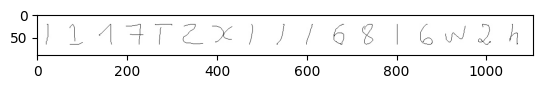

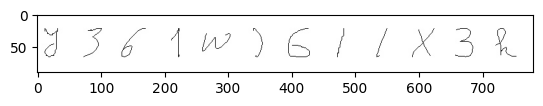

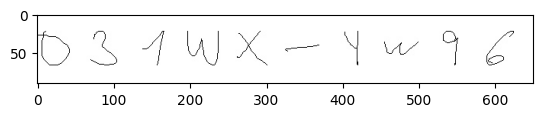

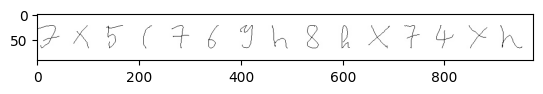

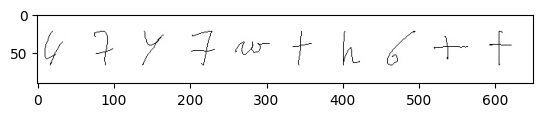

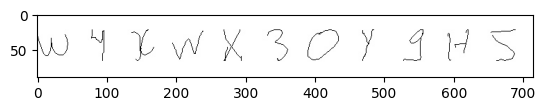

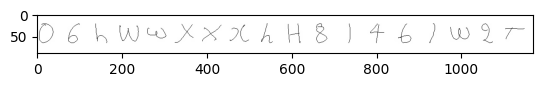

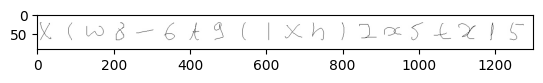

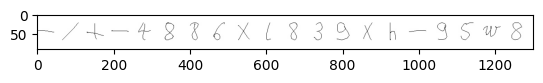

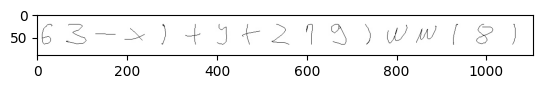

In [11]:
for key, value in images_pil.items():
    plt.imshow(images_char_to_image_str(value))
    plt.show()

In [12]:
#КЛАССИФИКАЦИЯ (k ближайших соседей)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
MAX_CHAR_PER_CLASS = 3000

data = []
target = []
for chr in characters:
    orig_chr = chr if chr != "*" else "times"
    chr_dir = os.listdir(os.path.join(path_to_folder, orig_chr))
    random_images = random.sample(chr_dir, min(MAX_CHAR_PER_CLASS, len(chr_dir)))
    for random_image in random_images:
        try:
            image = Image.open(os.path.join(path_to_folder, orig_chr, random_image)).convert("RGB")
            data.append(np.array(image).flatten())
            target.append(chr)
        except Exception:
            pass
        
print(data)
print(target)

[array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255, 255, 255], dtype=uint8), array([255, 255, 255, ..., 255

In [13]:
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=14)
param_grid = {"n_neighbors": [i for i in range(1, 5 + 1)]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'n_neighbors': 1}

In [14]:
model = KNeighborsClassifier(n_neighbors=grid_search.best_params_["n_neighbors"])
model.fit(X_train, y_train)
accuracy_list = []
predicted = model.predict(X_test)
print(f"Mean accuracy on test set: {accuracy_score(predicted, y_test)}")

Mean accuracy on test set: 0.8285405210493104


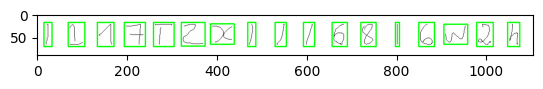

,117t2X),168,6w2h [',' '(' '1' '7' 't' '2' '2' ',' ',' ',' '1' '3' ',' '6' 'w' ',' 'h']


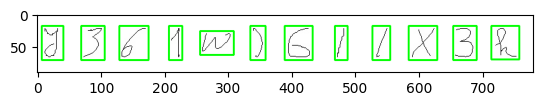

y361w)6,1X3h [')' '3' '6' '1' 'w' ')' '6' ',' ',' '1' '3' '(']


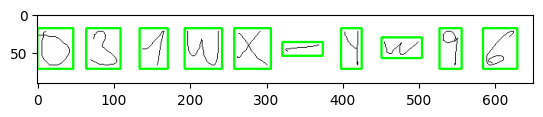

031w*-yw96 [')' ',' '1' 'w' '*' '-' '4' '2' '1' '(']


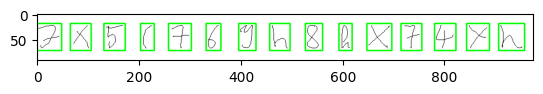

7*5(76yh8hX74*h [',' ',' '5' '(' '-' '6' ')' 'h' '0' '(' '(' ')' '4' ',' 'h']


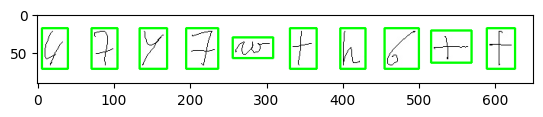

47y7w+h6++ [',' ')' 'y' '4' '2' 't' '+' '6' '-' '+']


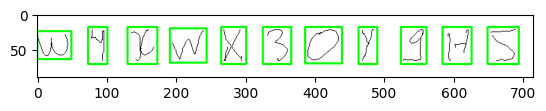

w4XwX30y9h5 ['1' '4' '(' 'w' ',' '3' '0' ',' '9' '-' 't']


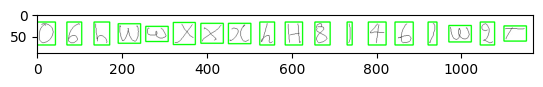

06hww**Xhh8)46)w2t ['0' '6' 'h' 'w' 't' '*' '*' 'X' 'h' '-' '3' ')' '4' '(' ')' 'w' '2' 't']


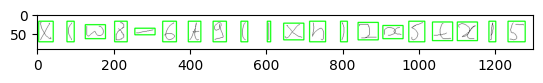

*(w8-6t9(,*h)2X5tX15 [',' '(' '2' ',' '-' '6' 't' ')' '(' ',' '*' ',' ',' ')' 't' '5' 't' 'X'
 '1' '5']


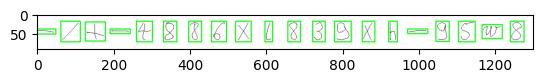

-,+-4886*(839*h-95w8 ['-' ',' '1' '-' '+' '3' '(' '(' ',' '(' ',' '3' '(' ',' 'h' '-' '9' '-'
 '(' '3']


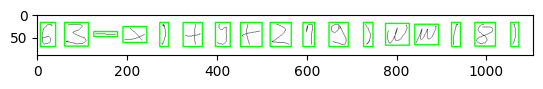

63-*)+y+279)ww18, ['1' '3' '-' '*' ')' '-' 'y' '-' '2' '1' '1' ')' 'w' 'w' '(' '-' ',']
Mean accuracy on recognition set: 0.5175460487225193


In [15]:
# РАСПОЗНАВАНИЕ
def resize_to_normal(image):
    width, height = image.size

    new_image = Image.new("RGB", (IMAGE_SIZE, IMAGE_SIZE), (255, 255, 255))
    new_image.paste(image, ((IMAGE_SIZE - width) // 2, (IMAGE_SIZE - height) // 2))

    return new_image

accuracy_list = []
solution = dict()
for key, value in images_pil.items():
    pil_image = images_char_to_image_str(images_pil[key])
    image = np.array(pil_image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (7, 7), 12)
    gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
    gray = cv2.bitwise_not(gray)

    contours, _ = cv2.findContours(gray.copy(), cv2.RETR_EXTERNAL, 2)
    boundings = sorted([cv2.boundingRect(c_) for c_ in contours], key=lambda x: x[0])

    if len(boundings) != len(key):  # Check for mismatch
        print(f"Skipping key '{key}' due to contour mismatch: found {len(boundings)}, expected {len(key)}")
        continue

    vectors = []
    for bound in boundings:
        x, y, w, h = bound
        img = image[y:y + h, x:x + w]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        vectors.append(np.array(resize_to_normal(Image.fromarray(img))).flatten())

    plt.imshow(image)
    plt.show()

    predicted = model.predict(vectors)
    print(key, predicted)

    if len(predicted) != len(key):  # Another safety check
        print(f"Skipping key '{key}' due to prediction mismatch: predicted={len(predicted)}, expected={len(key)}")
        continue

    solution[key] = predicted
    accuracy_list.append(accuracy_score(predicted, list(key)))

print(f"Mean accuracy on recognition set: {np.mean(accuracy_list)}")


In [16]:
# Случайно удалите некоторые символы,и случайно добавьте символы в результат распознавания.
# Рассчитайте метрику CER.
def str_random_change(list_str_):
    delete_str_ = [chr for chr in list_str_ if random.random() > 0.1]
    modify_string = deepcopy(list_str_)
    for i in range(len(delete_str_)):
        if random.random() < 0.1:
            rand_chr = random.choice(characters)
            modify_string.insert(i, rand_chr)
    return modify_string

In [17]:
def cer_metric(original, predicted):
    errors = sum(1 for orig, pred in zip(original, predicted) if orig != pred)
    errors += abs(len(original) - len(predicted))
    return errors / len(original) if len(original) > 0 else 0 

In [18]:
cer = 0
for key in solution.keys():
    temp_1 = list(solution[key])
    temp_2 = str_random_change(temp_1)
    temp_1 = "".join(temp_1)
    temp_2 = "".join(temp_2)
    metric = cer_metric(temp_1, temp_2)
    cer += metric
    print(temp_1, temp_2, metric)

print(f"MEAN CER: {cer / len(solution)}")

,(17t22,,,13,6w,h ,0(174t22,,,)13,6w,h 1.0
)361w)6,,13( )361w5()6,,13( 0.75
),1w*-421( ),1w*-421( 0.0
,,5(-6)h0(()4,h 0,),5(-6)h0(()4,h 1.0666666666666667
,)y42t+6-+ ,1)y642t+6-+ 1.1
14(w,30,9-t 14(w,3*0,9-t 0.5454545454545454
06hwt**Xh-3)4()w2t 0631hwt**Xh-3)4()w2t 1.0
,(2,-6t)(,*,,)t5tX15 (1,(2,-6t)(,*,,)t5tX15 1.0
-,1-+3((,(,3(,h-9-(3 ,-,1-*+t3((,(,3(,h-9-(3 1.0
13-*)-y-211)ww(-, 13-*)-y-2116)hww(-, 0.47058823529411764
MEAN CER: 0.7932709447415329
